In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
from PIL import Image
import random
import os
# import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if isinstance(img, Image.Image):
                ax.imshow(img, **imshow_kwargs)
            else:
                ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [2]:
annType = []
# annType = annType[1]      #specify type here
catType = ['airplane','bus','cat','dog','pizza']
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))
dataDir='./coco'
dataType='train2014'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

Running demo for *[]* results.
loading annotations into memory...
Done (t=5.51s)
creating index...
index created!


In [ ]:
#initialize COCO detections api
# resFile='%s/results/%s_%s_fake%s100_results.json'
# resFile = resFile%(dataDir, prefix, dataType, annType)
# cocoDt=cocoGt.loadRes(resFile)

In [3]:
imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]
imgId

332

In [4]:
catIds = cocoGt.getCatIds(catNms=catType)
sets = [set(cocoGt.getImgIds(catIds=catIds[i])) for i in range(5)]
rg = [(i, len(sets[i]), catIds[i]) for i in range(5)]
rg.sort(key=lambda x: x[1])
rg

[(4, 2202, 59), (0, 2243, 5), (1, 2791, 6), (2, 2818, 17), (3, 3041, 18)]

In [5]:
print({cocoGt.getCatIds(catType[i])[0]: i  for i in range(len(catType))})
{i: catType[i] for i in range(len(catType))}

{5: 0, 6: 1, 17: 2, 18: 3, 59: 4}


{0: 'airplane', 1: 'bus', 2: 'cat', 3: 'dog', 4: 'pizza'}

In [16]:
train_set = set()
show_sets = []
for (i, length, cat)  in rg:
    ids = random.sample(sets[i]-train_set,1500)
    show_set = random.sample(ids,3)
    show_sets.append(show_set)
    train_set.update(ids)
print("training set: ", len(train_set))
test_set = set()
for (i, length, cat) in rg:
    test_set.update(random.sample(sets[i]-train_set-test_set,500))
print("test set: ", len(test_set))
print("overlap: ", 7500 - len(train_set - test_set))

imgs = cocoGt.loadImgs(train_set)
for im in imgs:
    path = 'resized/%s'%im['file_name']
    if os.path.exists(path):
        continue
    img = Image.open('%s/images/%s'%(dataDir, im['file_name'])).resize((64,64),resample=Image.Resampling.LANCZOS)
    img.save(path)
imgs = cocoGt.loadImgs(test_set)
for im in imgs:
    path = 'resized/%s'%im['file_name']
    if os.path.exists(path):
        continue
    img = Image.open('%s/images/%s'%(dataDir, im['file_name'])).resize((64,64),resample=Image.Resampling.LANCZOS)
    img.save(path)
print("resize done")

training set:  7500
test set:  2500
overlap:  0
resize done


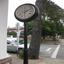

In [12]:
img = Image.open('resized/%s'%(cocoGt.loadImgs(64)[0]['file_name']))
# img.mode
img

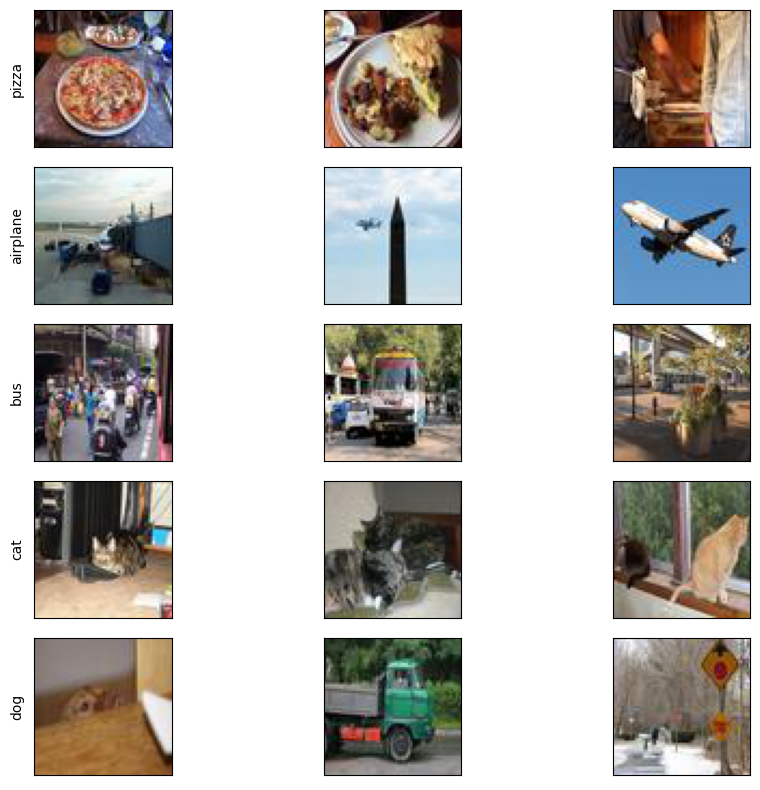

In [17]:
# selection of images
figs = [[Image.open('resized/%s'%cocoGt.loadImgs(list(s)[i])[0]['file_name']) for i in range(len(show_sets[0]))] for s in show_sets ]
plot(figs, row_title=[cocoGt.loadCats(rgi[2])[0]['name'] for rgi in rg])
plt.savefig("./5_class.jpg")

## 3.2 Image Classification using CNNs – Training and Validation

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tvt
from torch.utils.data.sampler import SubsetRandomSampler
import torch_directml
dml = torch_directml.device()
tensor1 = torch.tensor([2]).to(dml) # Note that dml is a variable, not a string!
tensor2 = torch.tensor([3]).to(dml)
dml_algebra = tensor1 + tensor2
dml_algebra.item()

5

In [12]:
class HW4Net1(nn.Module):
    def __init__(self):
        super(HW4Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class HW4Net2(nn.Module):
    def __init__(self):
        super(HW4Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class HW4Net3(nn.Module):
    def __init__(self):
        super(HW4Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv6 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv7 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv8 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv9 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv10= nn.Conv2d(32, 32, 3, padding=1)
        self.conv11= nn.Conv2d(32, 32, 3, padding=1)
        self.conv12= nn.Conv2d(32, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [13]:

class MyDataset(torch.utils.data.Dataset):
    xform = tvt.Compose([
        tvt.ToTensor(),
        # transform to range [-1, 1]:
        tvt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    def __init__(self, *, coco_dir="./coco", save_dir="./resized", train_num=1500, test_num=500, \
            catType=['airplane','bus','cat','dog','pizza'], update=False
        ):
        dataDir  = coco_dir
        prefix   = 'instances'
        dataType = 'train2014'
        annFile  = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
        cocoGt   = COCO(annFile)

        self.train_num = train_num
        self.test_num  = test_num
        self.dir = save_dir
        self.catId_to_label = {cocoGt.getCatIds(catType[i])[0]: i  for i in range(len(catType))}
        self.label_to_cat = {i: catType[i] for i in range(len(catType))}

        self.data, self.labels = self.gen_data_id(cocoGt, catType)
        self.gen_resized_image(cocoGt, dataDir, update=update)


    # return data and label(it is actually the categoryID)
    def gen_data_id(self, cocoGt, catType):
        catIds = cocoGt.getCatIds(catNms=catType)
        sets = [set(cocoGt.getImgIds(catIds=catIds[i])) for i in range(len(catType))]
        rg = [(i, len(sets[i]), catIds[i]) for i in range(len(catType))]
        rg.sort(key=lambda x: x[1])

        cat_sets = []
        m = self.train_num
        k = self.test_num
        n = self.train_num+self.test_num
        labels = [0]*n*len(catType)
        data = [0]*len(labels)
        for (i, length, cat)  in rg:
            s = sets[i]
            for s2 in cat_sets:
                s = s - s2
            ids = random.sample(s,n)
            cat_sets.append(set(ids))
            labels[i*m:(i+1)*m] = [cat]*m
            data[i*m:(i+1)*m] = ids[:m]
            labels[i*k+len(catType)*m:(i+1)*k+len(catType)*m] = [cat]*m
            data[i*k+len(catType)*m:(i+1)*k+len(catType)*m] = ids[m:]
        return cocoGt.loadImgs(data), labels

    def gen_resized_image(self, cocoGt, dataDir, new_size=(64,64), update=False):
        for im in self.data:
            path = '%s/%s'%(self.dir, im['file_name'])
            img = Image.open('%s/images/%s'%(dataDir, im['file_name']))
            if img.mode != 'RGB':
                # force update if it is not RGB
                img = img.convert('RGB')
            elif not update and os.path.exists(path):
                continue
            img = img.resize(new_size,resample=Image.Resampling.LANCZOS)
            img.save(path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        pil_image = Image.open('%s/%s'%(self.dir, self.data[index]['file_name']))
        tensor_img = self.xform(pil_image)
        tensor_lab = self.catId_to_label[self.labels[index]]
        return tensor_img, tensor_lab
classes = ['pizza','airplane','bus','cat','dog']
dataset = MyDataset(update=False, catType=classes)


loading annotations into memory...
Done (t=4.79s)
creating index...
index created!


In [18]:
# numbers per class
train_num = 1500
test_num = 500
ni=3
Net = [HW4Net1, HW4Net2, HW4Net3]
net = Net[ni-1]()
net = net.to(dml)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(), lr=1e-3, betas=(0.9, 0.99)
)

split = train_num*len(classes)
indices = list(range((train_num+test_num)*len(classes)))
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, num_workers=4,
                                           sampler=train_sampler)
valid_data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, num_workers=4,
                                           sampler=valid_sampler)

done


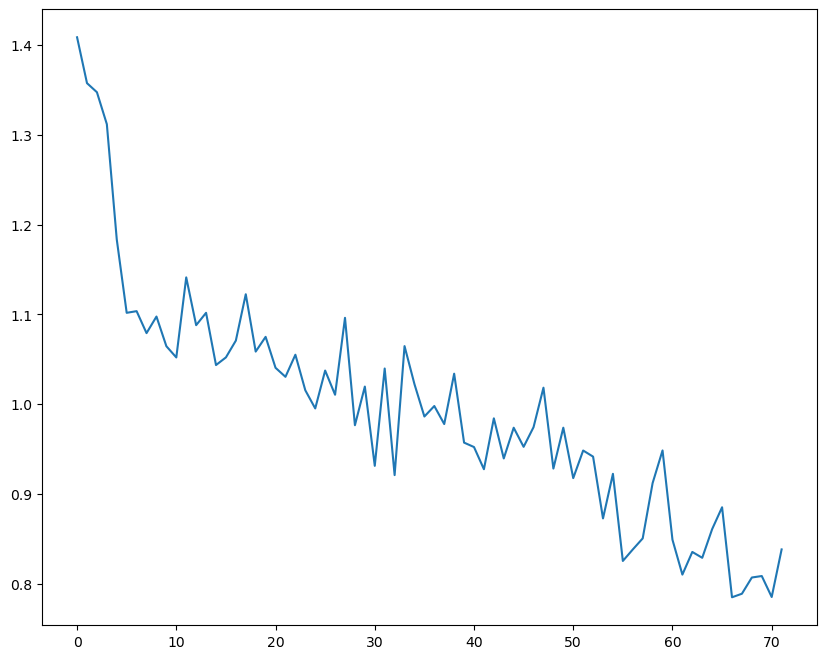

In [16]:
epochs = 12
# epochs = 2
loss_record = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_data_loader):
        inputs, labels = data
        inputs = inputs.to(dml)
        labels = labels.to(dml)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1)%100 == 0:
            # print("[epoch: %d, batch: %5d] loss: %.3f" \
            #     % (epoch+1, i+1, running_loss/100)            
            # )
            loss_record.append(running_loss/100)
            running_loss = 0.0
print("done")
plt.plot(loss_record,label="Net%d"%ni)

In [17]:
confusion_matrix = torch.zeros( (len(classes),len(classes)) )
# correct = 0
# total = 0
with torch.no_grad():
    for i, data in enumerate(valid_data_loader):
        images, labels = data
        images = images.to(dml)
        labels = labels.to(dml)
        outputs = net(images)
        _id, predicted = torch.max(outputs.data, 1)
        for label,prediction in zip(labels,predicted):
            confusion_matrix[label][prediction] += 1
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

confusion_matrix

tensor([[   0.,    8.,   88.,   66., 1338.],
        [   0., 1042.,  181.,   46.,  231.],
        [   0.,  180.,  805.,  103.,  412.],
        [   0.,   44.,  195.,  295.,  966.],
        [   0.,  154.,  240.,  217.,  889.]])

In [9]:
dataset.label_to_cat

{0: 'pizza', 1: 'airplane', 2: 'bus', 3: 'cat', 4: 'dog'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 3, 4, 0])
['pizza', 'cat', 'dog', 'pizza']
['dog', 'cat', 'bus', 'dog']


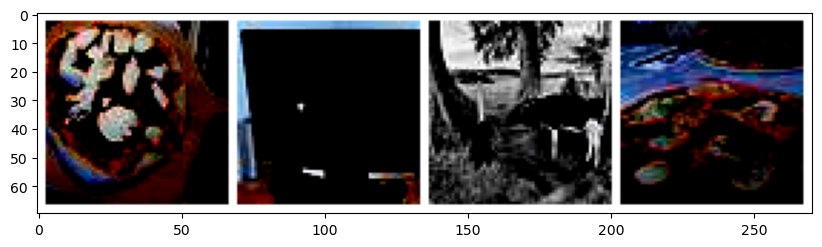

In [11]:
l = iter(valid_data_loader)
images, labels = next(l)
print(labels)
images = images.to(dml)
labels = labels.to(dml)
outputs = net(images)
_id, predicted = torch.max(outputs.data, 1)
print(list(map(lambda x: dataset.label_to_cat[x.item()],labels)))
print(list(map(lambda x: dataset.label_to_cat[x.item()],predicted)))
# plt.imshow(np.transpose(torchvision.utils.make_grid(images,
#                                                       normalize=False, padding=3, pad_value=255).cpu(), (1,2,0)))
# plt.show()
# outputs.data

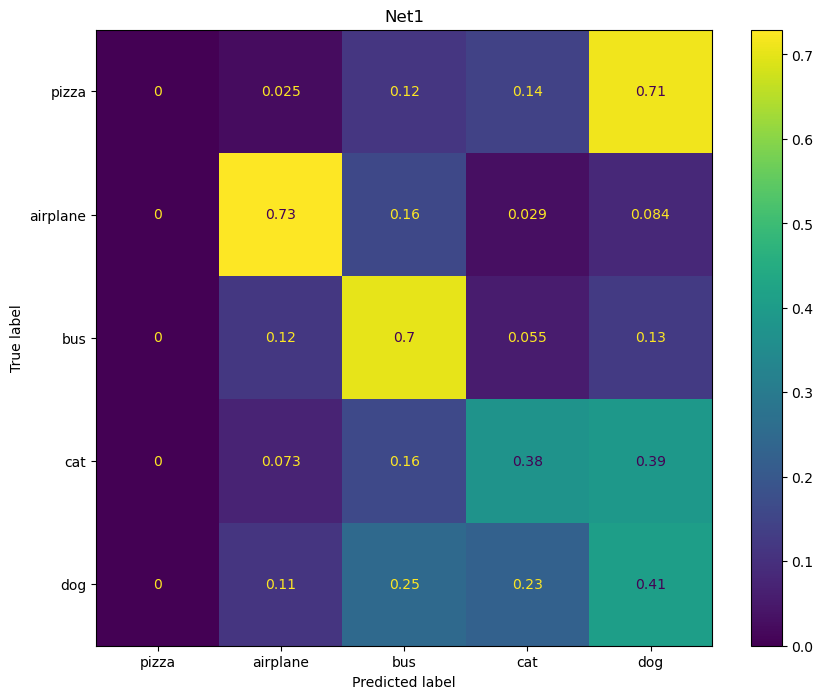

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

arr = np.array(
    [[   0.,   37.,  175.,  216., 1072.],
        [   0., 1094.,  236.,   44.,  126.],
        [   0.,  176., 1054.,   82.,  188.],
        [   0.,  110.,  243.,  563.,  584.],
        [   0.,  168.,  376.,  341.,  615.]]
)
arr = arr / np.linalg.norm(arr, ord=1, axis=1)
disp = ConfusionMatrixDisplay(
    arr,
    display_labels=classes
)
disp.plot()
plt.title("Net1")
plt.savefig("confusion1.jpg")
plt.show()
